
## Import of librairies and dataset

In [481]:
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import numpy as np


import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score


In [482]:
data = pd.read_csv("Walmart_Store_sales.csv")

display(data.head())

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


## EDA

### Data explore

In [483]:
print("Number of rows : {}".format(data.shape[0]))
print("Number of columns : {}".format(data.shape[1]))

display(data.head())


Number of rows : 150
Number of columns : 8


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


### Basics stats

In [484]:
print("Basics statistics: \n")
data_desc = data.describe(include='all')
display(data_desc)

print("\nPercentage of missing values: \n")
display(100*data.isnull().sum()/data.shape[0])

print("\nColumns type\n")
display(data.info())

Basics statistics: 



,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 



Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64


Columns type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


None

### Graph

#### barplot

In [485]:
for col in data.columns:
    fig = px.histogram(data, x=col)
    fig.show()


#### Correlation matrix

In [486]:
# Numeric columns
numeric_cols = ['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales']

# Matrice de corrélation
corr_matrix = data[numeric_cols].corr().round(2)

# Affichage avec Plotly
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns.tolist(),
    y=corr_matrix.index.tolist(),
    colorscale='Viridis',
    showscale=True
)
fig.update_layout(title="🔗 Matrice de corrélation (features numériques)")
fig.show()



Correlations :
- CPI / Store
- CPI /Unemployement
- CPI / Weekly_Sales
- Temperature / Store

#### Curve

In [487]:
import plotly.graph_objects as go
import pandas as pd

# Assure-toi que 'Date' est bien en datetime
data["Date"] = pd.to_datetime(data["Date"], errors="coerce")

# Liste des colonnes à tracer
cols_to_plot = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Weekly_Sales"]

# Boucle sur chaque variable à tracer
for col in cols_to_plot:
    fig = go.Figure()

    # Boucle sur chaque magasin unique
    for store_id in sorted(data["Store"].unique()):
        df_store = data[data["Store"] == store_id].sort_values("Date")
        if col in df_store.columns:
            fig.add_trace(go.Scatter(
                x=df_store["Date"],
                y=df_store[col],
                mode='lines',
                name=f"Store {store_id}",
                opacity=0.6
            ))

    fig.update_layout(
        title=f"Évolution de {col} pour les 20 magasins",
        xaxis_title="Date",
        yaxis_title=col,
        height=600,
        template="plotly_white",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    fig.show()


C:\Users\licor\AppData\Local\Temp\ipykernel_53412\205283721.py:5: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



### Missing values


#### df

In [488]:
df = data.copy()
# Suppression des lignes avec Weekly_Sales manquant
df = df.dropna(subset=["Weekly_Sales","Date"])

# Reset de l'index proprement
df.reset_index(drop=True, inplace=True)

# Affichage du nombre de lignes restantes
print(f"✅ Lignes restantes après suppression données manquantes 'date'&'Weekly_Sales' : {df.shape[0]}")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

df["Year"] = df["Date"].dt.year.astype("Int64")
df["Month"] = df["Date"].dt.month.astype("Int64")
df["Day"] = df["Date"].dt.day.astype("Int64")
df["DayOfWeek"] = df["Date"].dt.dayofweek.astype("Int64")
df["DayOfYear"] = df["Date"].dt.dayofyear.astype("Int64")
df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype("Int64")

display (df.head())

✅ Lignes restantes après suppression données manquantes 'date'&'Weekly_Sales' : 118


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek,DayOfYear,WeekOfYear
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18,4,49,7
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,4,84,12
2,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,4,148,21
3,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010,5,28,4,148,21
4,15.0,2011-06-03,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,4,154,22


In [489]:
# Suppression des lignes avec Weekly_Sales manquant
df = df.dropna(subset=["Weekly_Sales","Date"])

# Reset de l'index proprement
df.reset_index(drop=True, inplace=True)

# Affichage du nombre de lignes restantes
print(f"✅ Lignes restantes après suppression données manquantes 'date'&'Weekly_Sales' : {df.shape[0]}")


✅ Lignes restantes après suppression données manquantes 'date'&'Weekly_Sales' : 118


In [490]:
# miss values row
rows_with_nan = df[df.isnull().any(axis=1)]

print(f"Total nombre de lignes 'df' : {df.shape[0]}\n🔍 Nombre de lignes avec des valeurs manquantes : {rows_with_nan.shape[0]}")
display(rows_with_nan)


Total nombre de lignes 'df' : 118
🔍 Nombre de lignes avec des valeurs manquantes : 43


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek,DayOfYear,WeekOfYear
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18,4,49,7
3,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010,5,28,4,148,21
6,14.0,2010-12-10,2600519.26,0.0,30.54,3.109,NaN,NaN,2010,12,10,4,344,49
12,6.0,2010-04-30,1498080.16,NaN,68.91,2.780,211.894272,7.092,2010,4,30,4,120,17
13,13.0,2010-08-20,1997397.63,0.0,76.34,2.850,NaN,7.951,2010,8,20,4,232,33
14,2.0,2011-12-16,2432736.52,0.0,50.13,NaN,NaN,7.441,2011,12,16,4,350,50
21,3.0,2012-01-13,367438.62,0.0,51.86,3.261,NaN,6.833,2012,1,13,4,13,2
24,6.0,2011-08-26,1420405.41,0.0,NaN,3.523,217.270654,6.925,2011,8,26,4,238,34
27,14.0,2012-02-10,2077256.24,1.0,37.00,NaN,NaN,8.424,2012,2,10,4,41,6
30,18.0,2011-04-15,988157.72,0.0,NaN,3.823,134.278467,8.975,2011,4,15,4,105,15


#### Missing values by df global

##### Fuel_Price missing moving average

In [491]:
# Calcul des moyennes annuelles (tous magasins confondus)
annual_means = df.groupby("Year")["Fuel_Price"].mean().round(3)

# Initialiser la figure avec les courbes des magasins
fig = go.Figure()

# Tracer les courbes Fuel_Price par Store
stores = df["Store"].unique()
for store in stores:
    store_data = df[df["Store"] == store].sort_values("Date")

    fig.add_trace(go.Scatter(
        x=store_data["Date"],
        y=store_data["Fuel_Price"],
        mode="lines",
        name=f"Store {store}",
        line=dict(width=1),
        opacity=0.5
    ))

# Ajouter les traits horizontaux rouges pour chaque année
for year, avg in annual_means.items():
    start_date = pd.to_datetime(f"{year}-01-01")
    end_date = pd.to_datetime(f"{year}-12-31")

    fig.add_trace(go.Scatter(
        x=[start_date, end_date],
        y=[avg, avg],
        mode="lines",
        name=f"Moyenne {year}",
        line=dict(color="red", dash="dot", width=2)
    ))

# Layout
fig.update_layout(
    title="📈 Évolution de Fuel_Price par magasin + Moyennes annuelles (lignes rouges pointillées)",
    xaxis_title="Date",
    yaxis_title="Fuel_Price",
    height=600
)

fig.show()

# Affichage
print("📊 Moyennes annuelles de Fuel_Price (df) :")
for year, price in annual_means.items():
    print(f"  - {year} : {price} $")


📊 Moyennes annuelles de Fuel_Price (df) :
  - 2010 : 2.795 $
  - 2011 : 3.604 $
  - 2012 : 3.714 $


In [492]:
# Liste des lignes problématiques (NaN dans Fuel_Price + NaT dans Date)
lines_with_nat_date = []

# Remplir les valeurs manquantes avec la moyenne annuelle
for idx, row in df[df["Fuel_Price"].isna()].iterrows():
    date = row["Date"]
    if pd.isna(date):
        lines_with_nat_date.append(df.loc[idx])
        continue  # Ne pas remplir Fuel_Price, garder NaN
    year = date.year
    if year in annual_means:
        df.at[idx, "Fuel_Price"] = annual_means[year]

# Affichage clair des lignes non remplies à cause de Date manquante
if lines_with_nat_date:
    print("❗ Lignes avec Date manquante et Fuel_Price non remplie :\n")
    display(pd.DataFrame(lines_with_nat_date))
else:
    print("✅ Toutes les valeurs manquantes de Fuel_Price ont été remplies.")




✅ Toutes les valeurs manquantes de Fuel_Price ont été remplies.


In [493]:
# miss values row
rows_with_nan = df[df.isnull().any(axis=1)]

print(f"Total nombre de lignes 'df' : {df.shape[0]}\n🔍 Nombre de lignes avec des valeurs manquantes : {rows_with_nan.shape[0]}")

Total nombre de lignes 'df' : 118
🔍 Nombre de lignes avec des valeurs manquantes : 37


##### Temperature missing values

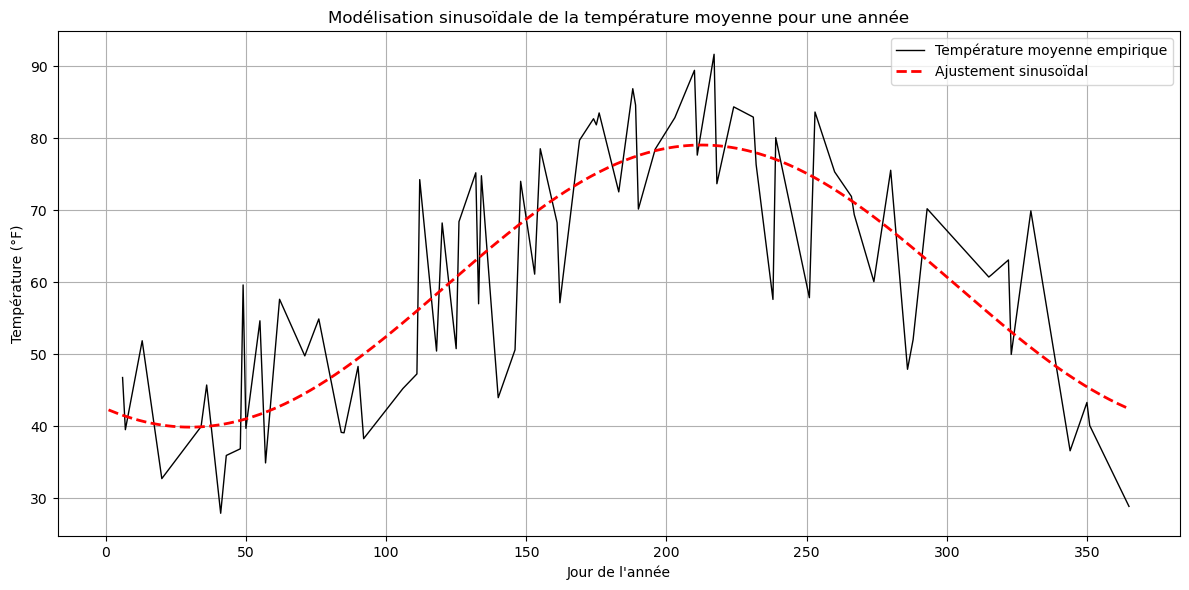

array([ 19.59334595, 121.2812337 ,  59.45213196])

In [494]:
df_sin = df.dropna(subset=["Date", "Temperature"])  # On garde seulement les dates valides et température

# Calcul du jour de l'année
df_sin["DayOfYear"] = df_sin["Date"].dt.dayofyear

# Température moyenne par jour de l'année
avg_temp_by_day = df_sin.groupby("DayOfYear")["Temperature"].mean().reset_index()

# Fonction sinusoïdale à ajuster
def sinusoidal(x, A, phi, B):
    return A * np.sin(2 * np.pi * (x - phi) / 365) + B

# Ajustement de la fonction sinusoïdale aux températures moyennes
x_data = avg_temp_by_day["DayOfYear"]
y_data = avg_temp_by_day["Temperature"]

params, _ = curve_fit(sinusoidal, x_data, y_data, p0=[20, 180, 60])  # Estimation initiale

# Génération de la courbe ajustée
x_fit = np.linspace(1, 365, 365)
y_fit = sinusoidal(x_fit, *params)

# Affichage
plt.figure(figsize=(12, 6))
plt.plot(x_data, y_data, label="Température moyenne empirique", color="black", linewidth=1)
plt.plot(x_fit, y_fit, label="Ajustement sinusoïdal", color="red", linestyle="--", linewidth=2)
plt.xlabel("Jour de l'année")
plt.ylabel("Température (°F)")
plt.title("Modélisation sinusoïdale de la température moyenne pour une année")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

params  # On retourne les paramètres pour les examiner ensuite


C:\Users\licor\AppData\Local\Temp\ipykernel_53412\4288450794.py:40: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

c:\Users\licor\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



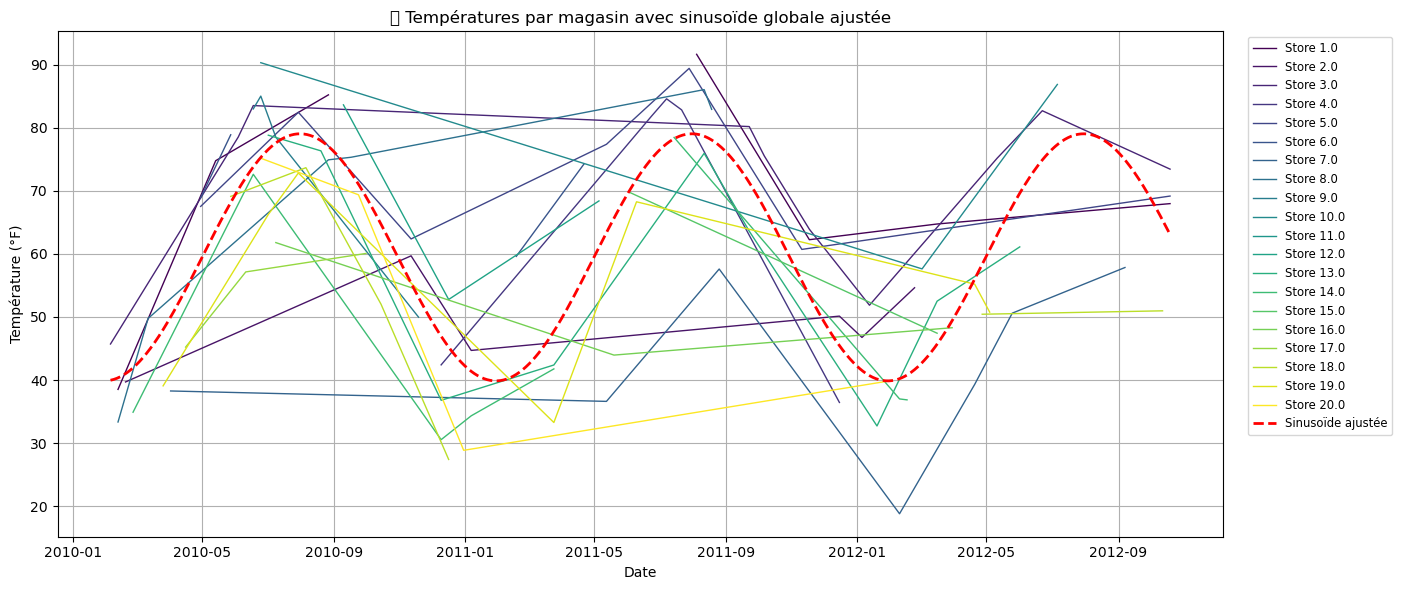

In [495]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Paramètres globaux de la sinusoïde ajustée sur 1 an
A = 19.59334595
phi = 121.2812337
B = 59.45213196

# 1. Générer toutes les dates du DataFrame
dates_unique = pd.date_range(start=df["Date"].min(), end=df["Date"].max())

# 2. Calculer le jour de l'année pour ces dates
day_of_year = dates_unique.dayofyear

# 3. Calculer la sinusoïde sur toutes les dates
sinusoid_values = A * np.sin(2 * np.pi * (day_of_year - phi) / 365) + B

# 4. Affichage
plt.figure(figsize=(14, 6))

# Générer une couleur unique par magasin
stores = sorted(df["Store"].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(stores)))

# Tracer les températures réelles pour chaque magasin avec sa couleur
for store, color in zip(stores, colors):
    store_data = df[df["Store"] == store].sort_values("Date")
    plt.plot(store_data["Date"], store_data["Temperature"], label=f"Store {store}", color=color, linewidth=1)

# Tracer la sinusoïde globale
plt.plot(dates_unique, sinusoid_values, 'r--', linewidth=2, label="Sinusoïde ajustée")

# Mise en forme
plt.title("📈 Températures par magasin avec sinusoïde globale ajustée")
plt.xlabel("Date")
plt.ylabel("Température (°F)")
plt.grid(True)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1), ncol=1, fontsize="small")
plt.tight_layout()
plt.show()




In [496]:
# Créer un mapping Date → Température sinusoidale
sinusoid_df = pd.DataFrame({
    "Date": dates_unique,
    "Sinusoid_Temperature": sinusoid_values
})

# Fusion avec df original pour récupérer température sinusoïdale par ligne
df = df.merge(sinusoid_df, on="Date", how="left")

# Remplir les NaN dans Temperature avec la sinusoïde
df["Temperature"] = df["Temperature"].fillna(df["Sinusoid_Temperature"])

# (Optionnel) supprimer la colonne d'appoint
df.drop(columns=["Sinusoid_Temperature"], inplace=True)



In [497]:
# miss values row
rows_with_nan = df[df.isnull().any(axis=1)]

print(f"Total nombre de lignes 'df' : {df.shape[0]}\n🔍 Nombre de lignes avec des valeurs manquantes : {rows_with_nan.shape[0]}")

Total nombre de lignes 'df' : 118
🔍 Nombre de lignes avec des valeurs manquantes : 28


##### Flag_holiday missing values

In [498]:
# USA holidays
holidays = pd.DataFrame([
    {"Holiday": "Winter Break",      "start_date": "2010-12-20", "End_date": "2011-01-03"},
    {"Holiday": "Spring Break",      "start_date": "2011-03-15", "End_date": "2011-04-01"},
    {"Holiday": "Summer Vacation",   "start_date": "2011-06-15", "End_date": "2011-08-31"},
    {"Holiday": "Thanksgiving Week", "start_date": "2011-11-21", "End_date": "2011-11-27"},
    {"Holiday": "Winter Break",      "start_date": "2011-12-19", "End_date": "2012-01-03"},
    {"Holiday": "Spring Break",      "start_date": "2012-03-15", "End_date": "2012-04-01"},
    {"Holiday": "Summer Vacation",   "start_date": "2012-06-15", "End_date": "2012-08-31"},
    {"Holiday": "Thanksgiving Week", "start_date": "2012-11-19", "End_date": "2012-11-25"},
    {"Holiday": "Winter Break",      "start_date": "2012-12-20", "End_date": "2013-01-03"},
], columns=["Holiday", "start_date", "End_date"])

# Convertir en datetime
holidays["start_date"] = pd.to_datetime(holidays["start_date"])
holidays["End_date"] = pd.to_datetime(holidays["End_date"])

# Affichage
display(holidays)


,Holiday,start_date,End_date
0,Winter Break,2010-12-20,2011-01-03
1,Spring Break,2011-03-15,2011-04-01
2,Summer Vacation,2011-06-15,2011-08-31
3,Thanksgiving Week,2011-11-21,2011-11-27
4,Winter Break,2011-12-19,2012-01-03
5,Spring Break,2012-03-15,2012-04-01
6,Summer Vacation,2012-06-15,2012-08-31
7,Thanksgiving Week,2012-11-19,2012-11-25
8,Winter Break,2012-12-20,2013-01-03


In [499]:
# Identifier les lignes où Holiday_Flag est manquant mais Date est présente
mask_nan_holiday = df["Holiday_Flag"].isna() & df["Date"].notna()

# Appliquer le remplissage
def infer_holiday_flag(date):
    for _, row in holidays.iterrows():
        if row["start_date"] <= date <= row["End_date"]:
            return 1  # C’est une période de vacances
    return 0  # Ce n’est pas une période de vacances

# Appliquer uniquement aux lignes avec NaN
df.loc[mask_nan_holiday, "Holiday_Flag"] = df.loc[mask_nan_holiday, "Date"].apply(infer_holiday_flag)

# Repérer les cas où on n’a pas pu remplir faute de date
dates_absentes = df[df["Holiday_Flag"].isna() & df["Date"].isna()]
if not dates_absentes.empty:
    print("⚠️ Certaines lignes ont une Holiday_Flag manquante et pas de date :")
    display(dates_absentes)

print("✅ Holiday_Flag complété selon les périodes de vacances scolaires.")


✅ Holiday_Flag complété selon les périodes de vacances scolaires.


In [500]:
# miss values row
rows_with_nan = df[df.isnull().any(axis=1)]

print(f"Total nombre de lignes 'df' : {df.shape[0]}\n🔍 Nombre de lignes avec des valeurs manquantes : {rows_with_nan.shape[0]}")

Total nombre de lignes 'df' : 118
🔍 Nombre de lignes avec des valeurs manquantes : 19


### missing values by store 

In [501]:
def generate_store_dataframes(df):
    """
    Génère un dictionnaire de DataFrames triés par date pour chaque Store (1 à 20),
    et affiche le total de lignes au final.
    """
    store_dfs = {}
    total_rows = 0

    for store_id in range(1, 21):
        store_df = df[df["Store"] == store_id].copy()
        store_df = store_df.sort_values(by="Date").reset_index(drop=True)
        store_dfs[store_id] = store_df
        nb_rows = store_df.shape[0]
        total_rows += nb_rows
        print(f"✅ Store {store_id} : {nb_rows} lignes")

    print(f"\n📊 Total de lignes dans tous les DataFrames : {total_rows}")
    return store_dfs




In [502]:
store_dfs = generate_store_dataframes(df)


✅ Store 1 : 8 lignes
✅ Store 2 : 6 lignes
✅ Store 3 : 10 lignes
✅ Store 4 : 6 lignes
✅ Store 5 : 7 lignes
✅ Store 6 : 6 lignes
✅ Store 7 : 7 lignes
✅ Store 8 : 6 lignes
✅ Store 9 : 4 lignes
✅ Store 10 : 3 lignes
✅ Store 11 : 1 lignes
✅ Store 12 : 5 lignes
✅ Store 13 : 9 lignes
✅ Store 14 : 9 lignes
✅ Store 15 : 3 lignes
✅ Store 16 : 4 lignes
✅ Store 17 : 5 lignes
✅ Store 18 : 7 lignes
✅ Store 19 : 8 lignes
✅ Store 20 : 4 lignes

📊 Total de lignes dans tous les DataFrames : 118


#### missing values by interploating

In [503]:
def interpolate_column_for_all_stores(store_dfs, column_name):
    """
    Interpole la colonne spécifiée (par interpolation linéaire bidirectionnelle)
    dans tous les DataFrames de store_dfs triés par date.
    
    Paramètres :
    - store_dfs : dict[int, pd.DataFrame], les DataFrames indexés par store_id
    - column_name : str, le nom de la colonne à interpoler
    """
    for store_id, df in store_dfs.items():
        if "Date" not in df.columns:
            print(f"⚠️ Store {store_id} : colonne 'Date' manquante.")
            continue
        if column_name not in df.columns:
            print(f"⚠️ Store {store_id} : colonne '{column_name}' manquante.")
            continue

        df = df.sort_values("Date").reset_index(drop=True)
        before_na = df[column_name].isna().sum()

        df[column_name] = df[column_name].interpolate(method="linear", limit_direction="both")

        after_na = df[column_name].isna().sum()
        store_dfs[store_id] = df

        print(f"✅ Store {store_id} : '{column_name}' interpolée ({before_na - after_na} valeurs comblées).")





In [504]:
interpolate_column_for_all_stores(store_dfs,"CPI")


✅ Store 1 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 2 : 'CPI' interpolée (1 valeurs comblées).
✅ Store 3 : 'CPI' interpolée (2 valeurs comblées).
✅ Store 4 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 5 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 6 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 7 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 8 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 9 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 10 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 11 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 12 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 13 : 'CPI' interpolée (1 valeurs comblées).
✅ Store 14 : 'CPI' interpolée (3 valeurs comblées).
✅ Store 15 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 16 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 17 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 18 : 'CPI' interpolée (1 valeurs comblées).
✅ Store 19 : 'CPI' interpolée (0 valeurs comblées).
✅ Store 20 : 'CPI' in

In [505]:
interpolate_column_for_all_stores(store_dfs,"Unemployment")

✅ Store 1 : 'Unemployment' interpolée (1 valeurs comblées).
✅ Store 2 : 'Unemployment' interpolée (1 valeurs comblées).
✅ Store 3 : 'Unemployment' interpolée (0 valeurs comblées).
✅ Store 4 : 'Unemployment' interpolée (0 valeurs comblées).
✅ Store 5 : 'Unemployment' interpolée (1 valeurs comblées).
✅ Store 6 : 'Unemployment' interpolée (0 valeurs comblées).
✅ Store 7 : 'Unemployment' interpolée (0 valeurs comblées).
✅ Store 8 : 'Unemployment' interpolée (1 valeurs comblées).
✅ Store 9 : 'Unemployment' interpolée (1 valeurs comblées).
✅ Store 10 : 'Unemployment' interpolée (0 valeurs comblées).
✅ Store 11 : 'Unemployment' interpolée (0 valeurs comblées).
✅ Store 12 : 'Unemployment' interpolée (0 valeurs comblées).
✅ Store 13 : 'Unemployment' interpolée (0 valeurs comblées).
✅ Store 14 : 'Unemployment' interpolée (2 valeurs comblées).
✅ Store 15 : 'Unemployment' interpolée (1 valeurs comblées).
✅ Store 16 : 'Unemployment' interpolée (0 valeurs comblées).
✅ Store 17 : 'Unemployment' inter

In [506]:
# Concaténation des DataFrames de store_dfs en un seul DataFrame
df_final = pd.concat(store_dfs.values(), ignore_index=True)



In [507]:
print("Number of rows : {}".format(df_final.shape[0]))
print("Number of columns : {}".format(df_final.shape[1]))

# miss values row
rows_with_nan = df_final[df_final.isnull().any(axis=1)]

print(f"\nNombre de lignes avec des valeurs manquantes : {rows_with_nan.shape[0]}")
display(df_final.head())


Number of rows : 118
Number of columns : 14

Nombre de lignes avec des valeurs manquantes : 0


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek,DayOfYear,WeekOfYear
0,1.0,2010-02-12,1641957.44,1.0,38.510000,2.548,211.242170,8.106,2010,2,12,4,43,6
1,1.0,2010-05-14,1494251.50,0.0,74.780000,2.854,210.337426,7.808,2010,5,14,4,134,19
2,1.0,2010-08-27,1449142.92,0.0,85.220000,2.619,211.567306,7.787,2010,8,27,4,239,34
3,1.0,2011-05-27,1466046.67,0.0,67.846042,3.786,215.503788,7.682,2011,5,27,4,147,21
4,1.0,2011-08-05,1624383.75,1.0,91.650000,3.684,215.544618,7.962,2011,8,5,4,217,31


### outliers

In [508]:
# Liste des colonnes numériques à vérifier
Num_features = ['Unemployment']

# Création du masque des outliers sur le df_final complet
outliers_mask = pd.Series(False, index=df_final.index)

for col in Num_features:
    mean = df_final[col].mean()
    std = df_final[col].std()
    outlier_min = mean - 3 * std
    outlier_max = mean + 3 * std

    # Cumul des lignes considérées comme outliers
    outliers_mask |= (df_final[col] < outlier_min) | (df_final[col] > outlier_max)

# Séparation des lignes
df_outliers = df_final[outliers_mask]
df_final = df_final[~outliers_mask]

# Affichage des résultats
print(f"✅ Nombre de lignes après suppression des outliers : {df_final.shape[0]}")

# miss values row
rows_with_nan = df_final[df_final.isnull().any(axis=1)]

print(f"\nNombre de lignes avec des valeurs manquantes : {rows_with_nan.shape[0]}")

display (df_final.head())

✅ Nombre de lignes après suppression des outliers : 113

Nombre de lignes avec des valeurs manquantes : 0


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek,DayOfYear,WeekOfYear
0,1.0,2010-02-12,1641957.44,1.0,38.510000,2.548,211.242170,8.106,2010,2,12,4,43,6
1,1.0,2010-05-14,1494251.50,0.0,74.780000,2.854,210.337426,7.808,2010,5,14,4,134,19
2,1.0,2010-08-27,1449142.92,0.0,85.220000,2.619,211.567306,7.787,2010,8,27,4,239,34
3,1.0,2011-05-27,1466046.67,0.0,67.846042,3.786,215.503788,7.682,2011,5,27,4,147,21
4,1.0,2011-08-05,1624383.75,1.0,91.650000,3.684,215.544618,7.962,2011,8,5,4,217,31


#### cleaning 

In [509]:
df_clean = df_final.copy()
df_clean.drop(columns=["Date", "DayOfWeek", "Day","DayOfYear"], inplace=True)


In [510]:
df_clean

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear
0,1.0,1641957.44,1.0,38.510000,2.548,211.242170,8.106,2010,2,6
1,1.0,1494251.50,0.0,74.780000,2.854,210.337426,7.808,2010,5,19
2,1.0,1449142.92,0.0,85.220000,2.619,211.567306,7.787,2010,8,34
3,1.0,1466046.67,0.0,67.846042,3.786,215.503788,7.682,2011,5,21
4,1.0,1624383.75,1.0,91.650000,3.684,215.544618,7.962,2011,8,31
...,...,...,...,...,...,...,...,...,...,...
113,19.0,1468350.36,0.0,74.891182,3.722,138.162900,8.150,2012,6,25
114,20.0,1973135.87,0.0,75.170000,2.808,204.567546,7.856,2010,6,25
115,20.0,1789687.65,0.0,69.370000,2.795,204.605386,7.527,2010,9,38
116,20.0,1799737.79,1.0,28.850000,3.179,204.643227,7.484,2010,12,52


## Machine Learning


##### Preprocessing

In [511]:
# Separate target variable Y from features X
target = 'Weekly_Sales'

print("Separating labels from features...")
Y = df_clean.loc[:,target]
X = df_clean.drop(target, axis = 1) # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    1641957.44
1    1494251.50
2    1449142.92
3    1466046.67
4    1624383.75
Name: Weekly_Sales, dtype: float64

   Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
0    1.0           1.0    38.510000       2.548  211.242170         8.106   
1    1.0           0.0    74.780000       2.854  210.337426         7.808   
2    1.0           0.0    85.220000       2.619  211.567306         7.787   
3    1.0           0.0    67.846042       3.786  215.503788         7.682   
4    1.0           1.0    91.650000       3.684  215.544618         7.962   

   Year  Month  WeekOfYear  
0  2010      2           6  
1  2010      5          19  
2  2010      8          34  
3  2011      5          21  
4  2011      8          31  



In [512]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("...Done.")


Dividing into train and test sets...
...Done.


In [513]:
numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
categorical_features = ["Store", "Holiday_Flag", "Year", "Month", "WeekOfYear"]

# Pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')


In [514]:
# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.\n')
print(X_train[0:5,:])


# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test)
print('...Done.')
print(X_test[0:5,:])


Performing preprocessings on train set...
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
31     5.0           0.0        82.46       2.640  211.927001         6.496   
72    13.0           0.0        42.38       3.435  128.616064         7.470   
115   20.0           0.0        69.37       2.795  204.605386         7.527   
112   19.0           0.0        50.76       4.124  138.033200         8.150   
22     3.0           0.0        82.70       3.346  225.306861         6.664   

     Year  Month  WeekOfYear  
31   2010      7          30  
72   2011      3          12  
115  2010      9          38  
112  2012      5          18  
22   2012      6          25  
...Done.

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 38 stored elements and shape (5, 76)>
  Coords	Values
  (0, 0)	1.1829802664680473
  (0, 1)	-1.2190703763402937
  (0, 2)	0.7975171889750571
  (0, 3)	-0.9042801802116147
  (0, 7)	1.0
  (0, 30)	1.0
  (0, 61)	1.0
  (1, 0)	-1.1702

c:\Users\licor\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning:

Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros




##### Train model

In [515]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [516]:
# 📊 Affichage des coefficients du modèle linéaire
print("📊 Coefficients du modèle linéaire :")

# Récupérer les noms des features après le preprocessing
feature_names = preprocessor.get_feature_names_out()

# Créer une DataFrame avec les coefficients
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": regressor.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Affichage
display(coef_df)

print(f"\n✅ Le nombre de coefficients est de {coef_df.shape[0]}")

# Interprétation simple
print("\n🔎 Interprétation :")
print("Les coefficients montrent l'effet de chaque variable sur les ventes hebdomadaires (Weekly_Sales).")
print("✔️ Coeff positif → variable associée à une hausse des ventes.")
print("❌ Coeff négatif → variable associée à une baisse des ventes.")
print("⚠️ Pour les variables catégorielles (ex: Store_2), l'effet est comparé à une catégorie de référence.")


📊 Coefficients du modèle linéaire :


,Feature,Coefficient
14,cat__Store_13.0,2.068566e+06
6,cat__Store_4.0,2.022472e+06
12,cat__Store_10.0,1.954108e+06
20,cat__Store_19.0,1.569853e+06
15,cat__Store_14.0,1.379146e+06
...,...,...
63,cat__WeekOfYear_32.0,2.997774e+04
51,cat__WeekOfYear_20.0,-2.173105e+04
54,cat__WeekOfYear_23.0,-1.246465e+04
68,cat__WeekOfYear_38.0,8.619023e+03



✅ Le nombre de coefficients est de 76

🔎 Interprétation :
Les coefficients montrent l'effet de chaque variable sur les ventes hebdomadaires (Weekly_Sales).
✔️ Coeff positif → variable associée à une hausse des ventes.
❌ Coeff négatif → variable associée à une baisse des ventes.
⚠️ Pour les variables catégorielles (ex: Store_2), l'effet est comparé à une catégorie de référence.



##### Performance assessment

In [517]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[ 288867.29009765 1806521.3546502  1891999.1281477  1350988.68372398
  464539.60226902  410928.92059    1465229.32548129 2149619.02301426
  396968.60394667  280707.48368475 1401578.78600635 1891612.18907903
  338271.61474088 1839263.74615821 1963037.65941263 2036230.96269896
 1483372.03888612 1573631.38758185  929424.51379304 1999945.83119273
 1519164.91019494  335570.35658405  374462.74552667 1065452.03830721
  233167.09332484  513108.69511725 1507793.20302434  561145.54228828
 1949063.56423965  614253.56743874 2003723.23341923  416418.70448407
  857402.87052748 1166119.3648602  2348908.49431093 2089637.62471336
  535796.94391199  597878.4150849  1921816.58934204 1953542.86998248
 1932385.03130151 1488563.49406645  262935.62115075 1659605.34109945
  875213.97696938 1637255.8384321  2035577.3956597  1646865.88037446
  757737.78095974  878075.64083971  987642.3160348  1864746.2279814
  570617.49932325 1942268.86161157 1990371.09171198 1942342.7675

In [518]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)


Predictions on test set...
...Done.
[2197556.49756933 1391088.47160927 1729907.89388793 1919541.19697555
 1647164.11696999  258979.51743161 1672315.83360091 2321200.24206444
  441579.93498557 2585808.38205779  879464.49100205  449817.29955124
  560440.79588425 1971786.36948314  273079.3353815  1537727.33454805
 2031746.9407973  2075956.28146401 2279132.84839552  864277.50191514
 1325670.21161213  805584.74916406 1749392.34549054]


In [519]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9963773236659882
R2 score on test set :  0.9487854359471403


In [520]:
scores = cross_val_score(regressor,X_train, Y_train, cv=10)
avg = scores.mean()
std = scores.std()
print('Cross-validated accuracy : {}\nstandard deviation : {}'.format(avg, std))

Cross-validated accuracy : 0.9160520695396025
standard deviation : 0.05083583707229929


##### 4 - Regularization

Ridge and Lasso both help avoid overfitting: 
- Ridge reduces coefficient values
- Lasso selects the most important variables by removing the coefficient of less significant variables

<a id='ridge'></a>
a - Ridge

In [521]:
ridge = Ridge()
print(ridge)
ridge.fit(X_train, Y_train)
# Print R^2 scores
print("R2 score on training set : ", ridge.score(X_train, Y_train))
print("R2 score on test set : ", ridge.score(X_test, Y_test))

Ridge()
R2 score on training set :  0.9556482714522694
R2 score on test set :  0.902713319851775


In [522]:
# 📊 Coefficients du modèle Ridge
print("📊 Coefficients du modèle Ridge :")

feature_names = preprocessor.get_feature_names_out()

ridge_coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": ridge.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

display(ridge_coef_df)

print(f"\n✅ Le nombre de coefficients est de {ridge_coef_df.shape[0]}")




📊 Coefficients du modèle Ridge :


,Feature,Coefficient
5,cat__Store_3.0,-745237.177704
7,cat__Store_5.0,-702735.598755
16,cat__Store_15.0,-586103.325767
21,cat__Store_20.0,565117.696318
15,cat__Store_14.0,555614.932718
...,...,...
33,cat__Month_10.0,8945.796413
64,cat__WeekOfYear_33.0,-8921.361611
63,cat__WeekOfYear_32.0,-8599.759750
55,cat__WeekOfYear_24.0,-5433.070795



✅ Le nombre de coefficients est de 76


<a id='lasso'></a>
a - Lasso

In [523]:
lasso = Lasso()
print(lasso)
lasso.fit(X_train, Y_train)
# Print R^2 scores
print("R2 score on training set : ", lasso.score(X_train, Y_train))
print("R2 score on test set : ", lasso.score(X_test, Y_test))

Lasso()
R2 score on training set :  0.996100481935805
R2 score on test set :  0.927171551283243


c:\Users\licor\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 79196894088.00972, tolerance: 4034163635.196278



In [524]:
# 📊 Coefficients du modèle Lasso
print("📊 Coefficients du modèle Lasso :")

feature_names = preprocessor.get_feature_names_out()

lasso_coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lasso.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

display(lasso_coef_df)

print(f"\n✅ Le nombre de coefficients est de {lasso_coef_df.shape[0]}")

nb_zero = (lasso_coef_df["Coefficient"] == 0).sum()
print(f"❌ Nombre de coefficients mis à zéro par Lasso : {nb_zero}")



📊 Coefficients du modèle Lasso :


,Feature,Coefficient
7,cat__Store_5.0,-1.247832e+06
5,cat__Store_3.0,-1.202373e+06
11,cat__Store_9.0,-1.171609e+06
17,cat__Store_16.0,-9.804919e+05
16,cat__Store_15.0,-9.693925e+05
...,...,...
2,num__CPI,-1.564757e+04
47,cat__WeekOfYear_16.0,1.446356e+04
67,cat__WeekOfYear_37.0,1.332598e+04
74,cat__WeekOfYear_49.0,1.149657e+04



✅ Le nombre de coefficients est de 76
❌ Nombre de coefficients mis à zéro par Lasso : 0


##### Hyperparameter optimization

optimization ridge

In [525]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Modèle Ridge de base
regressor = Ridge()

# Grille de valeurs élargie pour alpha
params = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]
}

# GridSearchCV avec validation croisée
print("🔍 Grid search Ridge...")
best_ridge = GridSearchCV(regressor, param_grid=params, cv=10)
best_ridge.fit(X_train, Y_train)
print("✅ ...Done.")
print("🔧 Meilleur alpha :", best_ridge.best_params_)
print("📊 R² moyen en validation croisée :", best_ridge.best_score_)

# Calcul des R²
r2_train = best_ridge.score(X_train, Y_train)  # R² sur le train
Y_pred = best_ridge.predict(X_test)            # Prédiction sur le test
r2_test = r2_score(Y_test, Y_pred)             # R² sur le test

# Affichage des scores
print("\n🎯 Évaluation du modèle Ridge final :")
print(f"✅ R² entraînement : {r2_train:.4f}")
print(f"✅ R² test         : {r2_test:.4f}")


🔍 Grid search Ridge...
✅ ...Done.
🔧 Meilleur alpha : {'alpha': 0.01}
📊 R² moyen en validation croisée : 0.9138708110177161

🎯 Évaluation du modèle Ridge final :
✅ R² entraînement : 0.9961
✅ R² test         : 0.9457


In [526]:
# 📊 Coefficients du meilleur modèle Ridge
print("📊 Coefficients du meilleur modèle Ridge :")

# Récupération des coefficients
ridge_best_coef = best_ridge.best_estimator_.coef_

# Création du DataFrame
ridge_coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": ridge_best_coef
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Affichage
display(ridge_coef_df)

# Synthèse
print(f"\n✅ Nombre de coefficients : {ridge_coef_df.shape[0]}")


📊 Coefficients du meilleur modèle Ridge :


,Feature,Coefficient
7,cat__Store_5.0,-1.226843e+06
5,cat__Store_3.0,-1.191325e+06
11,cat__Store_9.0,-1.146019e+06
17,cat__Store_16.0,-9.012488e+05
15,cat__Store_14.0,8.412665e+05
...,...,...
45,cat__WeekOfYear_13.0,2.623728e+04
24,cat__Year_2012.0,2.174636e+04
63,cat__WeekOfYear_32.0,1.792689e+04
68,cat__WeekOfYear_38.0,-1.135949e+04



✅ Nombre de coefficients : 76


optimization lasso 

In [527]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Modèle Lasso
regressor = Lasso(max_iter=10000)

# Grille élargie pour alpha
params = {'alpha': [0.01, 0.1, 1, 10, 100, 500, 1000, 5000, 10000]}


# GridSearchCV
print("🔍 Grid search Lasso...")
best_lasso = GridSearchCV(regressor, param_grid=params, cv=10)
best_lasso.fit(X_train, Y_train)
print("✅ ...Done.")
print("🔧 Meilleur alpha :", best_lasso.best_params_)
print("📊 R² moyen en validation croisée :", best_lasso.best_score_)

# Calcul des R²
r2_train = best_lasso.score(X_train, Y_train)
Y_pred = best_lasso.predict(X_test)
r2_test = r2_score(Y_test, Y_pred)

# Affichage
print("\n🎯 Évaluation du modèle Lasso final :")
print(f"✅ R² entraînement : {r2_train:.4f}")
print(f"✅ R² test         : {r2_test:.4f}")


🔍 Grid search Lasso...


c:\Users\licor\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 47301132586.03653, tolerance: 3592434231.1294565

c:\Users\licor\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 51843788492.244514, tolerance: 3633558601.442238

c:\Users\licor\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 65775966419.00659, tolerance: 3636417681.4092526

c:\Users\licor\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 57755217021.74941, tol

✅ ...Done.
🔧 Meilleur alpha : {'alpha': 1000}
📊 R² moyen en validation croisée : 0.9508074280102992

🎯 Évaluation du modèle Lasso final :
✅ R² entraînement : 0.9906
✅ R² test         : 0.9554


c:\Users\licor\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 18672115587.405296, tolerance: 3602000935.2633953



In [528]:
# Récupérer les coefficients du meilleur modèle Lasso
lasso_best_coef = best_lasso.best_estimator_.coef_

# Refaire un DataFrame lisible
lasso_coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lasso_best_coef
}).sort_values(by="Coefficient", key=abs, ascending=False)

display(lasso_coef_df)

# Compter combien de coefficients ont été mis à zéro
zero_count = (lasso_coef_df["Coefficient"] == 0).sum()
print(f"📉 Coefficients mis à zéro par Lasso : {zero_count} / {len(lasso_coef_df)}")


,Feature,Coefficient
7,cat__Store_5.0,-1.225211e+06
5,cat__Store_3.0,-1.136825e+06
11,cat__Store_9.0,-1.063306e+06
17,cat__Store_16.0,-9.535699e+05
16,cat__Store_15.0,-8.681652e+05
...,...,...
46,cat__WeekOfYear_15.0,-0.000000e+00
47,cat__WeekOfYear_16.0,0.000000e+00
50,cat__WeekOfYear_19.0,-0.000000e+00
53,cat__WeekOfYear_22.0,-0.000000e+00


📉 Coefficients mis à zéro par Lasso : 33 / 76


In [529]:
# Print R^2 scores
print("RIDGE / R2 score on training set : ", best_ridge.score(X_train, Y_train))
print("RIDGE / R2 score on test set : ", best_ridge.score(X_test, Y_test))
print()
print("LASSO / R2 score on training set : ", best_lasso.score(X_train, Y_train))
print("LASSO / R2 score on test set : ", best_lasso.score(X_test, Y_test))

RIDGE / R2 score on training set :  0.9960697788039677
RIDGE / R2 score on test set :  0.9456714362930851

LASSO / R2 score on training set :  0.990581226875569
LASSO / R2 score on test set :  0.9554124890890402


graphiques

In [530]:
import plotly.express as px
import pandas as pd

# Préparer le DataFrame pour Plotly (long format)
coef_long = coef_comparison[["Feature", "Linear", "Ridge (GS)", "Lasso (GS)"]].melt(
    id_vars="Feature", var_name="Modèle", value_name="Coefficient"
)

# Tri pour un affichage propre
coef_long["abs_coef"] = coef_long["Coefficient"].abs()
coef_long = coef_long.sort_values(by="abs_coef", ascending=True)

# Graphique interactif
fig = px.bar(
    coef_long,
    x="Coefficient",
    y="Feature",
    color="Modèle",
    orientation="h",
    title="📊 Comparaison interactive des coefficients<br>Linear vs Ridge vs Lasso (GridSearch)",
    height=1000
)

fig.update_layout(barmode="group", yaxis_title="Variables", xaxis_title="Valeur du coefficient")
fig.show()
